**Import the necessary libraries**

In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from pathlib import Path
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [9]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.8.0


**Rescaling the pixels**

In [2]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.15)

test_generator = ImageDataGenerator(rescale=1./255)

**Splitting the data into training,testing and validation**

In [3]:
train_data_dir = "/content/drive/MyDrive/CovidCV/train"
test_data_dir = "/content/drive/MyDrive/CovidCV/test"

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(150, 150),
                                               classes=['covid','normal'],
                                               class_mode='binary',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(150, 150),
                                               classes=['covid','normal'],
                                               class_mode='binary',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(150, 150),
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)

Found 7028 images belonging to 2 classes.
Found 1239 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


**Resizing the image**

In [4]:
input_shape = (150, 150, 3)
optim_1 = tf.keras.optimizers.Adam(learning_rate=0.0001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

**Setting up the model**

In [5]:
pre_trained_model =  tf.keras.applications.ResNet50(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
for layer in pre_trained_model.layers:
      layer.trainable=False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [6]:
x = Flatten()(pre_trained_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  
x = Dense(n_classes, activation='sigmoid')(x)    

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = optim_1, 
              loss = tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/CovidCV/resnet_50.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

**Training the model**

In [ ]:
history = model.fit(traingen,
                    batch_size=BATCH_SIZE,
                    epochs=n_epochs,
                    validation_data=validgen,
                    steps_per_epoch=n_steps,
                    validation_steps=n_val_steps,
                    callbacks=[tl_checkpoint_1, early_stop])

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 0.7592 - accuracy: 0.6570
Epoch 1: val_loss improved from inf to 0.49028, saving model to /content/drive/MyDrive/CovidCV/resnet_50.hdf5
109/109 [==============================] - 997s 9s/step - loss: 0.7592 - accuracy: 0.6570 - val_loss: 0.4903 - val_accuracy: 0.7780
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.7622
Epoch 2: val_loss improved from 0.49028 to 0.44454, saving model to /content/drive/MyDrive/CovidCV/resnet_50.hdf5
109/109 [==============================] - 55s 503ms/step - loss: 0.4874 - accuracy: 0.7622 - val_loss: 0.4445 - val_accuracy: 0.7788
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8254
Epoch 3: val_loss improved from 0.44454 to 0.39015, saving model to /content/drive/MyDrive/CovidCV/resnet_50.hdf5
109/109 [==============================] - 53s 482ms/step - loss: 0.3936 - accuracy: 0.8254 - val_loss: 0.39

**Result**

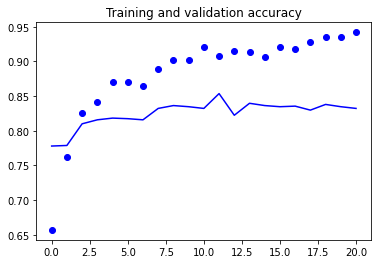

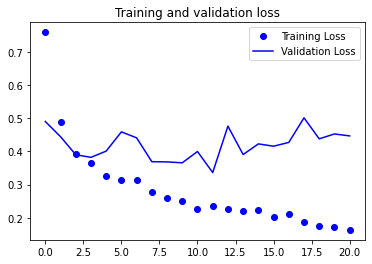

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Accuracy**

In [ ]:
acc = history.history['accuracy'][-1]
loss = history.history['loss'][-1]
print('Training Accuracy:',acc);
print('Training loss:',loss)

Training Accuracy: 0.942130982875824
Training loss: 0.16357126832008362


**Loading the weights of the saved model for prediction**

In [7]:
model.load_weights('/content/drive/MyDrive/CovidCV/resnet_50.hdf5')
preds_ft = model.predict(testgen)
pred_classes_ft = np.argmax(preds_ft, axis=1)

In [8]:
true_classes = testgen.classes
print(true_classes)

[0 0 0 ... 1 1 1]


In [ ]:
from sklearn.metrics import accuracy_score

acc_ft = accuracy_score(true_classes, pred_classes_ft)
print("Test Accuracy: {:.2f}%".format(acc_ft * 100))

Test Accuracy: 88.70%


**Evaluation metrics**

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(true_classes, pred_classes_ft)
print("Precision: {:.2f}%".format(precision))

# recall: tp / (tp + fn)
recall = recall_score(true_classes, pred_classes_ft)
print("Recall: {:.2f}%".format(recall))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(true_classes, pred_classes_ft)
print("F1 score: {:.2f}%".format(f1))

Precision: 0.93%
Recall: 0.83%
F1 score: 0.88%


In [ ]:
# confusion matrix
matrix = confusion_matrix(true_classes, pred_classes_ft)
print(matrix)

[[939  61]
 [165 835]]


**Test a sample image**

In [ ]:
from keras.preprocessing import image

img = image.load_img("/content/drive/MyDrive/CovidCV/test/normal/lfkdkdjdj (37).jpg",target_size=(150,150))
img = np.asarray(img).astype("float32")
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(output)

if output[0][0] > output[0][1]:
    print("Image is predicted as covid")
else:
    print("Image is predicted as normal")


[[1.0000000e+00 1.8241679e-11]]
Image is predicted as covid


## **EXPLAINABLE AI**

###**IMPLEMENTATION OF LIME**

In [10]:
!pip install lime

     |████████████████████████████████| 275 kB 29.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e960422cbd6df4bee3585f5c296d38aff29831349e71e871359c4a93ddd6ad62
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


**Testing a covid sample image**

In [47]:
img = testgen[10][10]
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(output)

if output[0][0] > output[0][1]:
    print("Image is predicted as covid")
else:
    print("Image is predicted as normal")

[[0.71956253 0.18923515]]
Image is predicted as covid


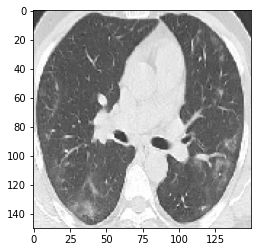

In [48]:
plt.imshow(testgen[10][10])

**Calculating superpixels**

In [49]:
Xi = img[0].astype("double")
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

21

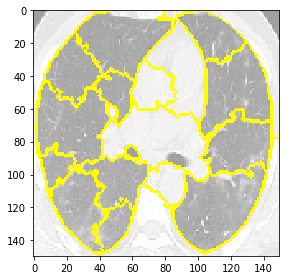

In [50]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [51]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [52]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

**Visualizing perturbed images**

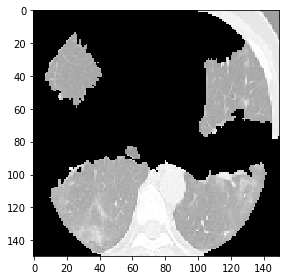

In [53]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [55]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

**Calculating distances using cosine metric**

In [56]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

**Mapping distance values to weights**

In [57]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [58]:
class_to_explain = 0
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.24450415,  0.07896672, -0.07402024,  0.24886618,  0.0559503 ,
       -0.04778802,  0.0477696 , -0.09155641, -0.00361992,  0.09514559,
       -0.13996805,  0.06598704,  0.02786102,  0.03675631,  0.03710897,
        0.00379032, -0.01578316,  0.05896718, -0.04816111,  0.02486546,
        0.01528517])

In [59]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([1, 9, 0, 3])

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 149.5, 149.5, -0.5)

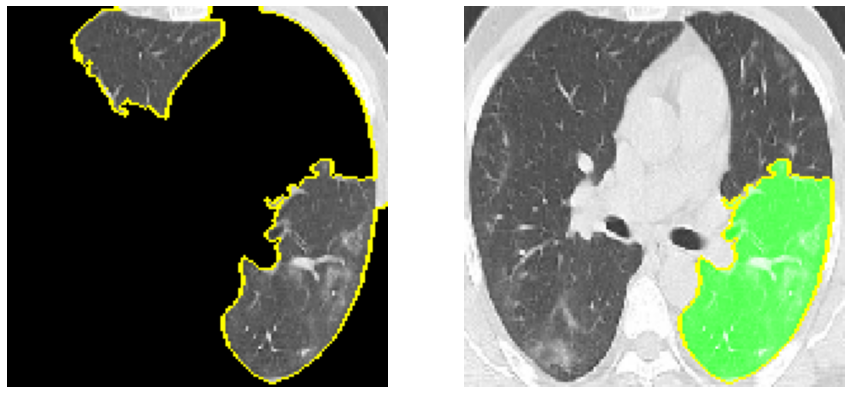

In [60]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(Xi, model.predict)
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=2, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

**Testing a normal sample image**

In [24]:
img = testgen[60][5]
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(output)

if output[0][0] > output[0][1]:
    print("Image is predicted as covid")
else:
    print("Image is predicted as normal")


[[0.45813707 0.49711955]]
Image is predicted as normal


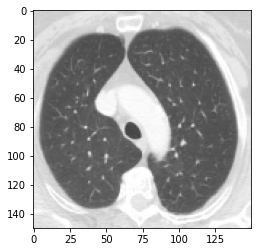

In [25]:
plt.imshow(testgen[60][5])

**Calculating superpixels**

In [26]:
Xi = img[0].astype("double")
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

17

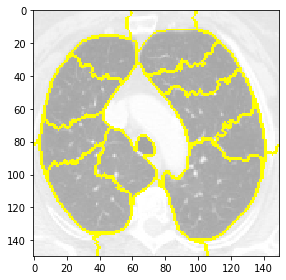

In [27]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [28]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1])

In [29]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

**Visualizing perturbed images**

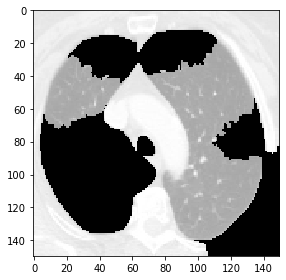

In [30]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[3],superpixels))

In [31]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

**Calculating distances using cosine metric**

In [32]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

**Mapping distance values to weights**

In [33]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [34]:
class_to_explain = 1
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.05538153, -0.05124718, -0.00795117,  0.06664561, -0.0306482 ,
       -0.02790758, -0.02577775,  0.02034795,  0.15096707, -0.0908085 ,
       -0.04474152, -0.0044102 , -0.19806814, -0.07270281,  0.13742464,
       -0.00415267,  0.05373173])

In [35]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([16,  3, 14,  8])

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 149.5, 149.5, -0.5)

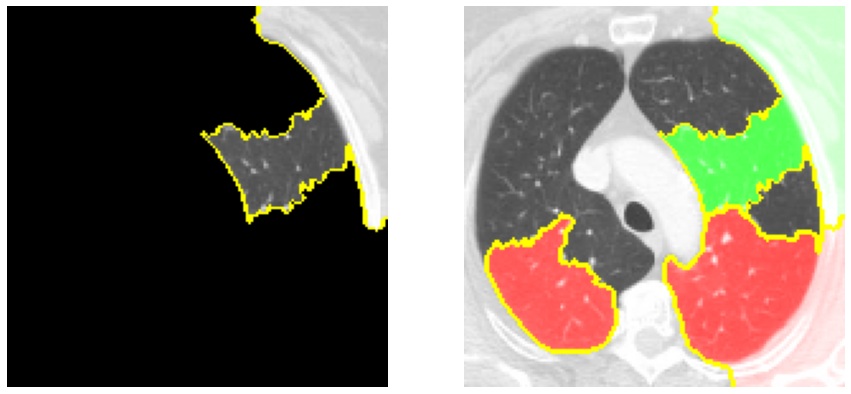

In [37]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(Xi, model.predict)
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

###**IMPLEMENTATION OF GRADCAM**

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

last_conv_layer_name = "conv5_block3_out"

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [42]:
def save_and_display_gradcam(img, heatmap, cam_path="/content/drive/MyDrive/CovidCV/GradCAM result/cam.jpg", alpha=0.8):
    img = np.uint8(255 * img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))
    return superimposed_img

**Testing a Covid sample Image**

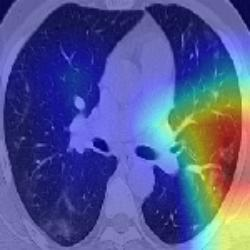

In [43]:
img = testgen[60][5]
img = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img, model, 'conv5_block3_out')
heatmap = cv2.resize(heatmap, (150, 150))
img = testgen[10][10]
img = cv2.resize(img, (250,250))
superimposed_img = save_and_display_gradcam(img, heatmap)

**Testing a normal sample Image**

(250, 250, 3)


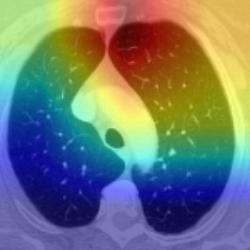

In [ ]:
img = testgen[12][7]
img = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img, model, 'conv5_block3_out')
heatmap = cv2.resize(heatmap, (150, 150))
img = testgen[60][5]
img = cv2.resize(img, (250,250))
print(img.shape)
superimposed_img = save_and_display_gradcam(img, heatmap)